# Fracture Detection using X-rays
## Members:

Gauri Jadhav

Khushi Desai

Riddhi Hindocha

Harneet Chahal




This project aims to develop a deep learning-based classification system to detect bone fractures from X-ray images. Our goal is to evaluate and compare the performance of different convolutional neural network architectures to determine the most effective model in terms of accuracy, interpretability, and generalization.

CNN (Custom Convolutional Neural Network),
MobileNetV2,
ResNet-18,
EfficientNet-B3

Each model will be assessed using standard performance metrics such as:

Accuracy,Precision, Recall, F1-score (Classification Report),ROC Curve and AUC Score,Confusion Matrix.  

Additionally, the project will include:

Explainability: Using tools like Grad-CAM or Integrated Gradients to visualize areas of the X-rays influencing the model's predictions.

Highlighting misclassified samples to identify common failure cases and better understand model limitations.

# Dependencies and Loading dataset from Kaggle

In [ ]:
# Step 1: Install and Set Up Kaggle API
!pip install kaggle  # Install Kaggle package
!pip install pytorch-lightning
!pip install grad-cam

import os
import json
import zipfile
import torch

# Step 2: Kaggle
kaggle_credentials = {
    "username": "gaurijadhav509",
    "key": "22ea54f029cbfa8ba32286b40c033738"
}

kaggle_path = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(kaggle_path), exist_ok=True)

with open(kaggle_path, "w") as f:
    json.dump(kaggle_credentials, f)

os.chmod(kaggle_path, 600)

# Step 3: Download the Dataset from Kaggle
!kaggle datasets download -d devbatrax/fracture-detection-using-x-ray-images

# Step 4: Extract the Dataset
import zipfile
import os

# Updated dataset_path to reflect the downloaded file name
dataset_path = "/content/fracture-detection-using-x-ray-images.zip"
extract_path = "/content/fracture-dataset"

with zipfile.ZipFile(dataset_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

# Step 5: Update Dataset Directories
train_dir = os.path.join(extract_path, "data/train")
test_dir = os.path.join(extract_path, "data/val")

import torch # This line imports the 'torch' module

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Dataset URL: https://www.kaggle.com/datasets/devbatrax/fracture-detection-using-x-ray-images
License(s): apache-2.0
fracture-detection-using-x-ray-images.zip: Skipping, found more recently modified local copy (use --force to force download)


# Import Libraries

In [ ]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule, Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from PIL import Image
from torchmetrics.classification import Accuracy
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from torchvision.models import resnet18, efficientnet_b3

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Function to collect image paths and class names


In [ ]:
def get_image_paths_labels(directory):
    classes, paths = [], []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            classes.append(root.split('/')[-1])
            paths.append(os.path.join(root, filename))
    return classes, paths

# Load training and testing data


In [ ]:
train_classes, train_paths = get_image_paths_labels(train_dir)
test_classes, test_paths = get_image_paths_labels(test_dir)

# Assign numerical labels to class names


In [ ]:
unique_classes = sorted(set(train_classes))
class_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}

# Create DataFrames for train and test

In [ ]:
train_data = pd.DataFrame({'path': train_paths, 'class': train_classes})
train_data['label'] = train_data['class'].map(class_to_index)

test_data = pd.DataFrame({'path': test_paths, 'class': test_classes})
test_data['label'] = test_data['class'].map(class_to_index)

# Custom Dataset class


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data.iloc[idx]['path'], self.data.iloc[idx]['label']
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


# Lightning DataModule for handling dataset loading and splitting


In [ ]:

import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split

class ImageDataModule(pl.LightningDataModule):
    def __init__(self, train_data, test_data, model_type,batch_size=32, train_percent=0.78, val_percent=0.07, test_percent=0.15):
        super().__init__()
        self.train_data = train_data
        self.test_data = test_data
        self.batch_size = batch_size
        self.model_type = model_type
        self.train_transform, self.val_transform = self.get_transforms()
        self.train_percent = train_percent
        self.val_percent = val_percent
        self.test_percent = test_percent

    def get_transforms(self):
      if self.model_type == 'efficientnet':
          #For efficientnet
          train_transform = transforms.Compose([
              transforms.RandomResizedCrop(300, scale=(0.8, 1.0)),
              transforms.RandomHorizontalFlip(),
              transforms.RandomRotation(15),
              transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
          val_transform = transforms.Compose([
              transforms.Resize((300, 300)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
      elif self.model_type in ['resnet', 'mobilenetv2']:
          #For Resnet
          train_transform = transforms.Compose([
              transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
              transforms.RandomHorizontalFlip(),
              transforms.RandomRotation(10),
              transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
          val_transform = transforms.Compose([
              transforms.Resize((224, 224)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
      else:
          #For CNN
          train_transform = val_transform = transforms.Compose([
              transforms.Resize((224, 224)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
      return train_transform, val_transform

    def setup(self, stage=None):
        # Create datasets for both train and test data
        train_dataset = CustomDataset(self.train_data, self.train_transform)
        test_dataset = CustomDataset(self.test_data, self.val_transform)

        # Combine both datasets into a single dataset
        combined_dataset = train_dataset + test_dataset  # Concatenate both datasets

        total_size = len(combined_dataset)
        print(f"Total size of combined dataset: {total_size}")

        # Calculate sizes based on the percentages
        train_size = int(total_size * self.train_percent)
        val_size = int(total_size * self.val_percent)
        test_size = total_size - train_size - val_size  # Ensure no leftover data

        # Split the dataset manually based on the calculated sizes
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            combined_dataset, [train_size, val_size, test_size]
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)


# Evaluation, Plotting and explainability, missclassified samples functions

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image


# Utility: Automatically get last conv layer for Grad-CAM
def get_target_layer(model):
    if hasattr(model, 'layer4'):  # ResNet
        return model.layer4[-1]
    elif hasattr(model, 'features'):  # EfficientNet
        return model.features[-1]
    else:  # Custom CNN
        for module in reversed(list(model.modules())):
            if isinstance(module, torch.nn.Conv2d):
                return module
    raise ValueError("No convolutional layer found!")


# Evaluation Function
def evaluate_model(model_name, model, dataloader, class_names, device='cuda'):
    print(f"\nEvaluating {model_name} Model...")

    model.to(device)
    model.eval()
    y_true, y_pred = [], []
    y_pred_proba = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(labels.tolist())
            y_pred.extend(torch.argmax(probs, dim=1).tolist())
            y_pred_proba.extend(probs.tolist())

    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=class_names)

    print(f"\nAccuracy: {acc * 100:.2f}%")
    print("\nClassification Report:\n")
    print(report)

    return y_true, y_pred, y_pred_proba


# Confusion Matrix Plot
def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"{model_name} Confusion Matrix Heatmap")
    plt.show()


def plot_misclassified_samples(model_name, model, dataloader, class_names, y_true, y_pred, device='cuda'):
    model.eval()

    # Find the first misclassified index
    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        if true != pred:
            image, _ = dataloader.dataset[i]
            plt.figure(figsize=(4, 4))
            plt.imshow(image.cpu().permute(1, 2, 0))
            plt.title(f"True: {class_names[true]}\nPred: {class_names[pred]}")
            plt.axis('off')
            plt.show()
            return  # Exit after showing one

    print("No misclassified samples found.")




# ROC Curve Plot
def plot_roc_curve(model_name, y_true, y_pred_proba, num_classes, class_names):
    plt.figure(figsize=(10, 7))
    y_true = np.array(y_true)
    y_scores = np.array(y_pred_proba)

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} - {class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# Grad-CAM Visualization
def visualize_gradcam(model, dataloader, class_names, device='cuda'):
    model.to(device)
    model.eval()
    target_layer = get_target_layer(model)
    cam = GradCAM(model=model, target_layers=[target_layer])

    images, labels = next(iter(dataloader))
    image = images[0].unsqueeze(0).to(device)
    label = labels[0].item()

    rgb_img = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
    input_tensor = preprocess_image(rgb_img, mean=[0.5]*3, std=[0.5]*3)

    grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(6, 6))
    plt.imshow(visualization)
    plt.title(f"Grad-CAM - True Label: {class_names[label]}")
    plt.axis('off')
    plt.show()

# Define,train, test and visualize CNN model


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | conv1     | Conv2d             | 168    | train
1 | conv2     | Conv2d             | 880    | train
2 | fc1       | Linear             | 5.6 M  | train
3 | fc2       | Linear             | 10.2 K | train
4 | fc3       | Linear             | 170    | train
5 | train_acc | MulticlassAccuracy | 0      | train
6 | val_acc   | Multiclass

Total size of combined dataset: 9463
Number of training images: 7381
Number of testing images: 1420
Number of validation images: 662


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Epoch 0 - Train Acc: 0.7333 | Val Acc: 0.8466
Train Loss: 0.5078 | Val Loss: 0.3424


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 - Train Acc: 0.8422 | Val Acc: 0.8959
Train Loss: 0.1391 | Val Loss: 0.1288


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 - Train Acc: 0.8920 | Val Acc: 0.9188
Train Loss: 0.0260 | Val Loss: 0.0792


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3 - Train Acc: 0.9188 | Val Acc: 0.9320
Train Loss: 0.0031 | Val Loss: 0.1126


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4 - Train Acc: 0.9350 | Val Acc: 0.9401
Train Loss: 0.0005 | Val Loss: 0.1104


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5 - Train Acc: 0.9458 | Val Acc: 0.9462
Train Loss: 0.0001 | Val Loss: 0.0972


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6 - Train Acc: 0.9536 | Val Acc: 0.9508
Train Loss: 0.0000 | Val Loss: 0.1047


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7 - Train Acc: 0.9594 | Val Acc: 0.9541
Train Loss: 0.0000 | Val Loss: 0.1084


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8 - Train Acc: 0.9639 | Val Acc: 0.9567
Train Loss: 0.0000 | Val Loss: 0.1179


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9 - Train Acc: 0.9675 | Val Acc: 0.9586
Train Loss: 0.0000 | Val Loss: 0.1183


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.



Evaluating CNN Model...

Accuracy: 98.24%

Classification Report:

               precision    recall  f1-score   support

    fractured       0.99      0.98      0.98       716
not fractured       0.98      0.99      0.98       704

     accuracy                           0.98      1420
    macro avg       0.98      0.98      0.98      1420
 weighted avg       0.98      0.98      0.98      1420



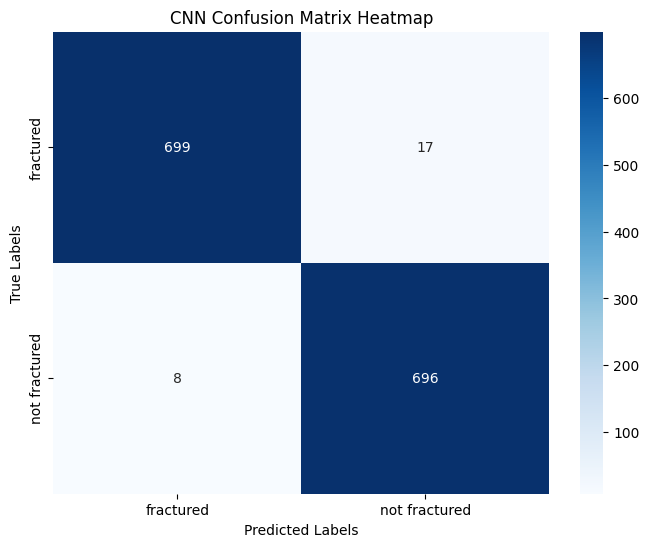

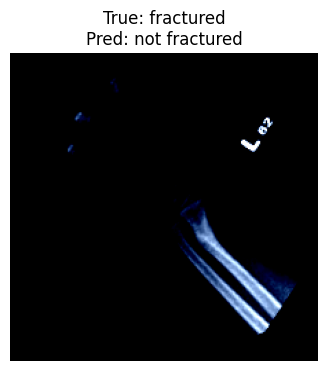

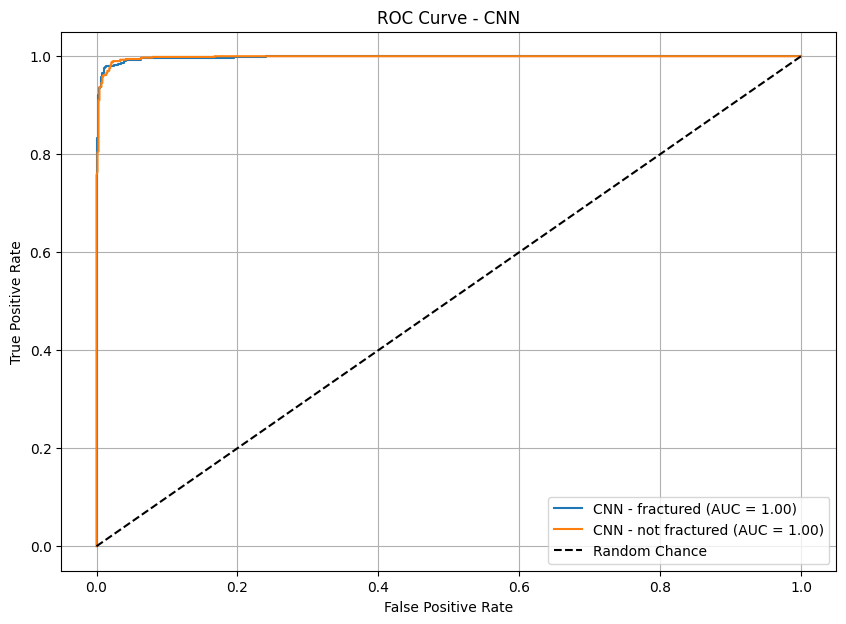

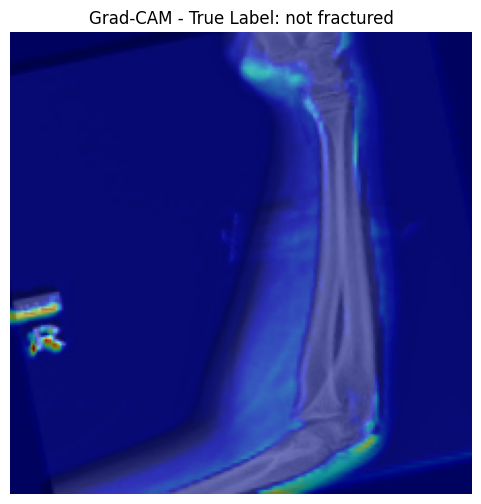

In [ ]:
class CNNModel(LightningModule):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        self.train_losses = []
        self.val_losses = []

        # Define accuracy metrics
        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc = MulticlassAccuracy(num_classes=num_classes)
        self.test_acc = MulticlassAccuracy(num_classes=num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        # Compute accuracy
        acc = self.train_acc(y_hat, y)
        self.train_losses.append(loss.detach())

        # Log loss and accuracy
        self.log('train_loss', loss, on_epoch=True, on_step=False, logger=True, sync_dist=True)
        self.log('train_acc', acc, on_epoch=True, on_step=True, logger=True, sync_dist=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        # Compute accuracy
        acc = self.val_acc(y_hat, y)
        self.val_losses.append(loss.detach())

        # Log loss and accuracy
        self.log('val_loss', loss, on_epoch=True, on_step=True, logger=True, sync_dist=True)
        self.log('val_acc', acc,  on_epoch=True, on_step=True, logger=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        # Compute accuracy
        acc = self.test_acc(y_hat, y)

        # Log loss and accuracy
        self.log('test_loss', loss, on_epoch=True, on_step=True, logger=True, sync_dist=True)
        self.log('test_acc', acc, on_epoch=True, on_step=True, logger=True, sync_dist=True)
        return loss

    def on_train_epoch_end(self):
        avg_train_loss = torch.stack(self.train_losses).mean()
        avg_val_loss = torch.stack(self.val_losses).mean()

        self.log('train_loss_epoch', avg_train_loss, on_epoch=True, logger=True)
        self.log('val_loss_epoch', avg_val_loss, on_epoch=True, logger=True)
        # Ensure accuracy stays on screen continuously, no resetting
        self.log('train_acc', self.train_acc.compute(), on_epoch=True, on_step=False, logger=True, sync_dist=True)
        self.log('val_acc', self.val_acc.compute(),  on_epoch=True, on_step=False, logger=True, sync_dist=True)
        self.log('test_acc', self.test_acc.compute(),  on_epoch=True, on_step=False, logger=True, sync_dist=True)

        print(f"Epoch {self.current_epoch} - Train Acc: {self.train_acc.compute().item():.4f} | Val Acc: {self.val_acc.compute().item():.4f}")
        print(f"Train Loss: {avg_train_loss.item():.4f} | Val Loss: {avg_val_loss.item():.4f}")

        self.train_losses.clear()
        self.val_losses.clear()

    def on_test_epoch_end(self):
        test_accuracy = self.test_acc.compute().item()
        print(f"Epoch {self.current_epoch} - Test Accuracy: {test_accuracy:.4f}")

if(device == 'cuda'):
   accelator = 'gpu'
else:
   accelator = 'cpu'

model_type = "cnn"
data_module = ImageDataModule(train_data, test_data, model_type)
data_module.setup()

# Print dataset information
print(f"Number of training images: {len(data_module.train_dataset)}")
print(f"Number of testing images: {len(data_module.test_dataset)}")
print(f"Number of validation images: {len(data_module.val_dataset)}")

# Create DataLoader
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

trainer = Trainer(max_epochs=10, accelerator=accelator, devices=1,logger=True)

# Initialize the CNN Model
cnn_model = CNNModel(num_classes=len(unique_classes))

# Train the CNN Model
trainer.fit(cnn_model, train_dataloaders=train_loader, val_dataloaders=val_loader)


y_true, y_pred, y_pred_proba = evaluate_model("CNN", cnn_model, test_loader, unique_classes, device)
plot_confusion_matrix(y_true, y_pred, unique_classes, "CNN")
plot_misclassified_samples("CNN", cnn_model, test_loader, unique_classes, y_true, y_pred, device)
plot_roc_curve("CNN", y_true, y_pred_proba, num_classes=len(unique_classes), class_names=unique_classes)
visualize_gradcam(cnn_model, test_loader, unique_classes, device)

# Define,train, test and visualize MobileNetV2 model

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | MobileNetV2        | 2.2 M  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Tota

Total size of combined dataset: 9463
Number of training images: 7381
Number of testing images: 1420
Number of validation images: 662


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Epoch 0 - Train Acc: 0.5922 | Val Acc: 0.6570
Train Loss: 0.6722 | Val Loss: 0.6104


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 - Train Acc: 0.6278 | Val Acc: 0.6227
Train Loss: 0.6049 | Val Loss: 0.6740


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 - Train Acc: 0.6591 | Val Acc: 0.6589
Train Loss: 0.5423 | Val Loss: 0.4847


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3 - Train Acc: 0.6865 | Val Acc: 0.6657
Train Loss: 0.4780 | Val Loss: 0.5993


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4 - Train Acc: 0.7110 | Val Acc: 0.6949
Train Loss: 0.4081 | Val Loss: 0.4201


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5 - Train Acc: 0.7326 | Val Acc: 0.7137
Train Loss: 0.3598 | Val Loss: 0.4012


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6 - Train Acc: 0.7531 | Val Acc: 0.7322
Train Loss: 0.2914 | Val Loss: 0.3638


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7 - Train Acc: 0.7714 | Val Acc: 0.7490
Train Loss: 0.2468 | Val Loss: 0.3167


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8 - Train Acc: 0.7872 | Val Acc: 0.7657
Train Loss: 0.2181 | Val Loss: 0.2258


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9 - Train Acc: 0.8019 | Val Acc: 0.7743
Train Loss: 0.1723 | Val Loss: 0.3579

Evaluating MobilenetV2 Model...

Accuracy: 82.11%

Classification Report:

               precision    recall  f1-score   support

    fractured       0.74      0.99      0.84       700
not fractured       0.98      0.66      0.79       720

     accuracy                           0.82      1420
    macro avg       0.86      0.82      0.82      1420
 weighted avg       0.86      0.82      0.82      1420



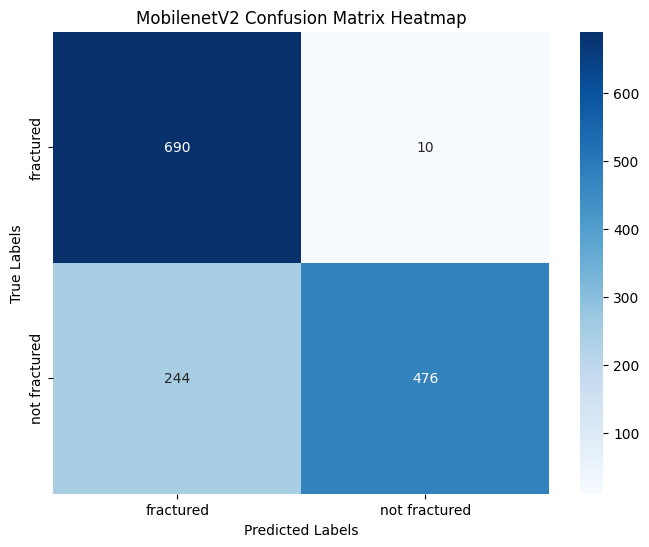

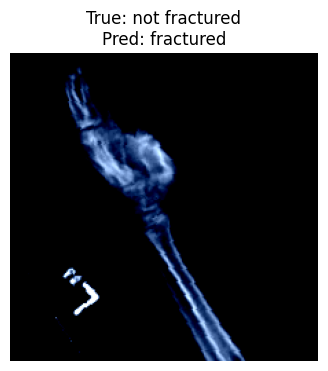

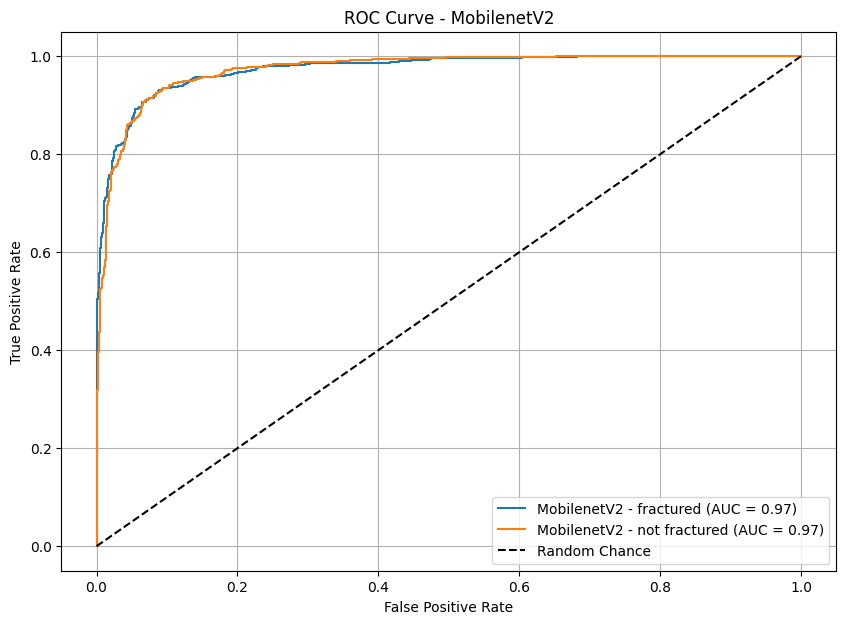

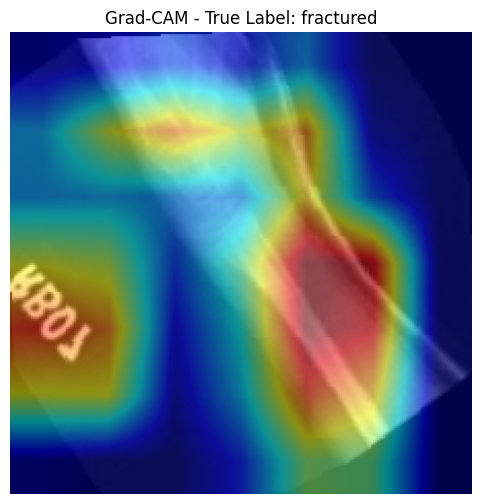

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import mobilenet_v2
from pytorch_lightning import LightningModule
from torchmetrics.classification import MulticlassAccuracy

class MobileNetModel(LightningModule):
    def __init__(self, num_classes):
        super(MobileNetModel, self).__init__()

        # Load pretrained MobileNetV2 and replace the classifier head
        self.model = mobilenet_v2(weights=None)  # or use weights="DEFAULT" if pretrained
        self.model.classifier[1] = nn.Linear(self.model.last_channel, num_classes)
        self.train_losses = []
        self.val_losses = []

        # Accuracy metrics
        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc = MulticlassAccuracy(num_classes=num_classes)
        self.test_acc = MulticlassAccuracy(num_classes=num_classes)

    def forward(self, x):
        return F.log_softmax(self.model(x), dim=1)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.train_acc(y_hat, y)
        self.train_losses.append(loss.detach())

        self.log('train_loss', loss, on_epoch=True, on_step=False, logger=True, sync_dist=True)
        self.log('train_acc', acc, on_epoch=True, on_step=True, logger=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.val_acc(y_hat, y)
        self.val_losses.append(loss.detach())

        self.log('val_loss', loss, on_epoch=True, on_step=True, logger=True, sync_dist=True)
        self.log('val_acc', acc, on_epoch=True, on_step=True, logger=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.test_acc(y_hat, y)

        self.log('test_loss', loss, on_epoch=True, on_step=True, logger=True, sync_dist=True)
        self.log('test_acc', acc, on_epoch=True, on_step=True, logger=True, sync_dist=True)
        return loss


    def on_train_epoch_end(self):
        avg_train_loss = torch.stack(self.train_losses).mean()
        avg_val_loss = torch.stack(self.val_losses).mean()

        self.log('train_loss_epoch', avg_train_loss, on_epoch=True, logger=True)
        self.log('val_loss_epoch', avg_val_loss, on_epoch=True, logger=True)
        # Ensure accuracy stays on screen continuously, no resetting
        self.log('train_acc', self.train_acc.compute(), on_epoch=True, on_step=False, logger=True, sync_dist=True)
        self.log('val_acc', self.val_acc.compute(),  on_epoch=True, on_step=False, logger=True, sync_dist=True)
        self.log('test_acc', self.test_acc.compute(),  on_epoch=True, on_step=False, logger=True, sync_dist=True)

        print(f"Epoch {self.current_epoch} - Train Acc: {self.train_acc.compute().item():.4f} | Val Acc: {self.val_acc.compute().item():.4f}")
        print(f"Train Loss: {avg_train_loss.item():.4f} | Val Loss: {avg_val_loss.item():.4f}")

        self.train_losses.clear()
        self.val_losses.clear()

    def on_test_epoch_end(self):
        print(f"Epoch {self.current_epoch} - Test Accuracy: {self.test_acc.compute():.4f}")


model_type = "mobilenetv2"
data_module = ImageDataModule(train_data, test_data, model_type)
data_module.setup()

# Print dataset information
print(f"Number of training images: {len(data_module.train_dataset)}")
print(f"Number of testing images: {len(data_module.test_dataset)}")
print(f"Number of validation images: {len(data_module.val_dataset)}")

# Create DataLoader
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

trainer = Trainer(max_epochs=10, accelerator=accelator, devices=1,logger=True)

# Initialize the CNN Model
mobilenet_model = MobileNetModel(num_classes=len(unique_classes))

# Train the CNN Model
trainer.fit(mobilenet_model, train_dataloaders=train_loader, val_dataloaders=val_loader)
y_true, y_pred, y_pred_proba = evaluate_model("MobilenetV2", mobilenet_model, test_loader, unique_classes, device)
plot_confusion_matrix(y_true, y_pred, unique_classes, "MobilenetV2")
plot_misclassified_samples("MobilenetV2", mobilenet_model, test_loader, unique_classes, y_true, y_pred, device)
plot_roc_curve("MobilenetV2", y_true, y_pred_proba, num_classes=len(unique_classes), class_names=unique_classes)
visualize_gradcam(mobilenet_model, test_loader, unique_classes, device)

# Define, train, test and visualize ResNet18 model


Total size of combined dataset: 9463
Number of training images: 7381
Number of testing images: 1420
Number of validation images: 662


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.ra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Epoch 0 - Train Acc: 0.8639 | Val Acc: 0.9246
Train Loss: 0.2894 | Val Loss: 0.1471


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 - Train Acc: 0.9176 | Val Acc: 0.9570
Train Loss: 0.0720 | Val Loss: 0.0260


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 - Train Acc: 0.9416 | Val Acc: 0.9672
Train Loss: 0.0299 | Val Loss: 0.0312


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3 - Train Acc: 0.9537 | Val Acc: 0.9737
Train Loss: 0.0292 | Val Loss: 0.0218


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4 - Train Acc: 0.9612 | Val Acc: 0.9786
Train Loss: 0.0261 | Val Loss: 0.0049


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5 - Train Acc: 0.9662 | Val Acc: 0.9800
Train Loss: 0.0267 | Val Loss: 0.0451


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6 - Train Acc: 0.9702 | Val Acc: 0.9821
Train Loss: 0.0168 | Val Loss: 0.0126


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7 - Train Acc: 0.9733 | Val Acc: 0.9841
Train Loss: 0.0152 | Val Loss: 0.0052


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8 - Train Acc: 0.9756 | Val Acc: 0.9857
Train Loss: 0.0168 | Val Loss: 0.0058


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9 - Train Acc: 0.9779 | Val Acc: 0.9871
Train Loss: 0.0044 | Val Loss: 0.0019


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.



Evaluating ResNet-18 Model...

Accuracy: 99.93%

Classification Report:

               precision    recall  f1-score   support

    fractured       1.00      1.00      1.00       734
not fractured       1.00      1.00      1.00       686

     accuracy                           1.00      1420
    macro avg       1.00      1.00      1.00      1420
 weighted avg       1.00      1.00      1.00      1420



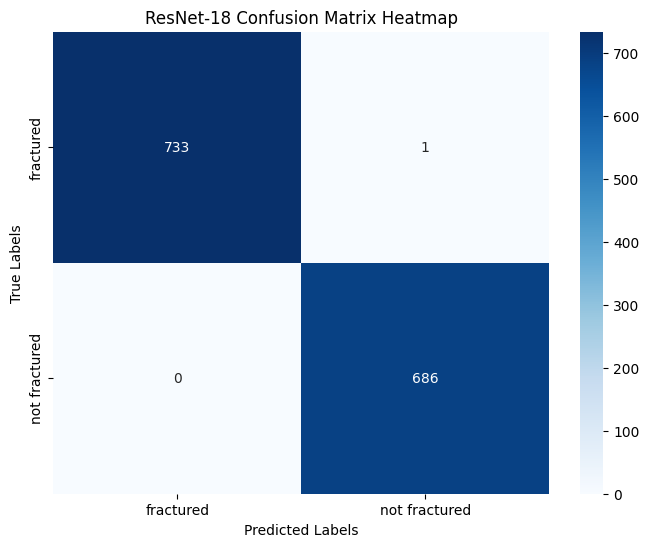

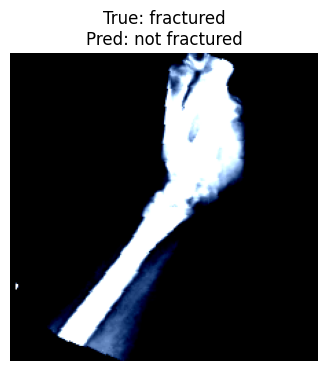

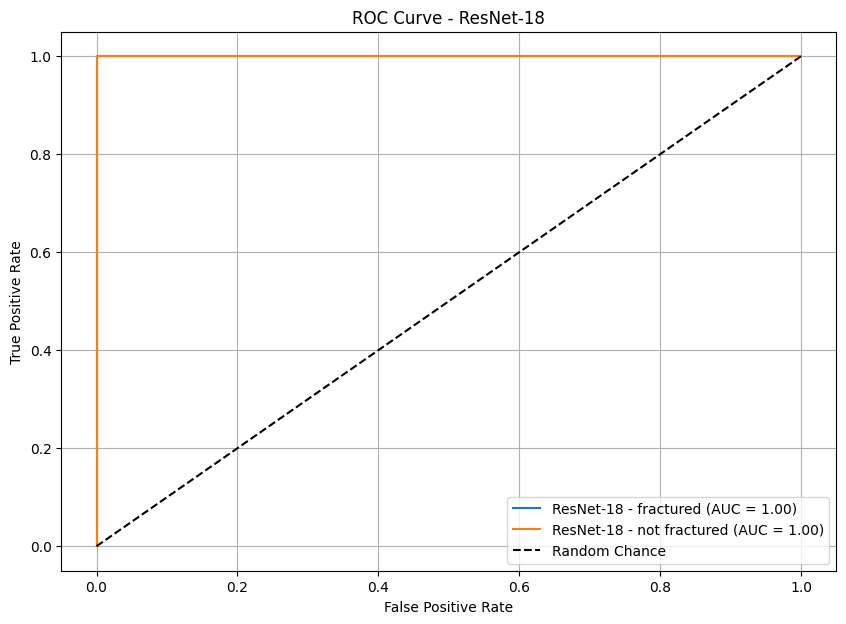

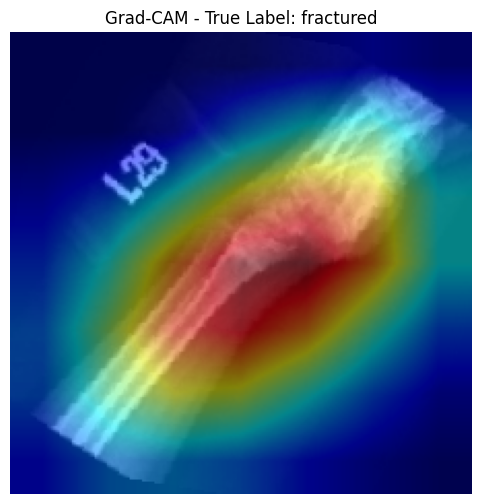

In [ ]:
from torchvision.models import resnet18
from pytorch_lightning import LightningModule
from torchmetrics.classification import MulticlassAccuracy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ResNetModel(LightningModule):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()

        # Load pretrained ResNet18 and replace the final layer with dropout + new classifier
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),  # Dropout to reduce overfitting
            nn.Linear(self.model.fc.in_features, num_classes)
        )
        self.train_losses = []
        self.val_losses = []

        # Accuracy metrics
        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc = MulticlassAccuracy(num_classes=num_classes)
        self.test_acc = MulticlassAccuracy(num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        # Use weight decay to prevent overfitting
        return optim.Adam(self.parameters(), lr=1e-4, weight_decay=1e-4)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.train_acc(y_hat.argmax(dim=1), y)

        self.train_losses.append(loss.detach())

        # print(f"[TRAIN] Batch {batch_idx} - Loss: {loss.item():.4f} | Acc: {acc.item():.4f}")
        self.log('train_loss', loss, on_epoch=True, on_step=True, logger=True)
        self.log('train_acc', acc,  on_epoch=True, on_step=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.val_acc(y_hat.argmax(dim=1), y)
        self.val_losses.append(loss.detach())

        # print(f"[VAL] Batch {batch_idx} - Loss: {loss.item():.4f} | Acc: {acc.item():.4f}")
        self.log('val_loss', loss,  on_epoch=True, on_step=True, logger=True)
        self.log('val_acc', acc,  on_epoch=True, on_step=True, logger=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.test_acc(y_hat.argmax(dim=1), y)

        # print(f"[TEST] Batch {batch_idx} - Loss: {loss.item():.4f} | Acc: {acc.item():.4f}")
        self.log('test_loss', loss, on_epoch=True, on_step=True, logger=True)
        self.log('test_acc', acc,  on_epoch=True, on_step=True, logger=True)
        return loss

    def on_train_epoch_end(self):
        avg_train_loss = torch.stack(self.train_losses).mean()
        avg_val_loss = torch.stack(self.val_losses).mean()

        self.log('train_loss_epoch', avg_train_loss, on_epoch=True, logger=True)
        self.log('val_loss_epoch', avg_val_loss, on_epoch=True, logger=True)
        # Ensure accuracy stays on screen continuously, no resetting
        self.log('train_acc', self.train_acc.compute(), on_epoch=True, on_step=False, logger=True, sync_dist=True)
        self.log('val_acc', self.val_acc.compute(),  on_epoch=True, on_step=False, logger=True, sync_dist=True)
        self.log('test_acc', self.test_acc.compute(),  on_epoch=True, on_step=False, logger=True, sync_dist=True)

        print(f"Epoch {self.current_epoch} - Train Acc: {self.train_acc.compute().item():.4f} | Val Acc: {self.val_acc.compute().item():.4f}")
        print(f"Train Loss: {avg_train_loss.item():.4f} | Val Loss: {avg_val_loss.item():.4f}")

        self.train_losses.clear()
        self.val_losses.clear()

    def on_test_epoch_end(self):
        test_accuracy = self.test_acc.compute().item()
        print(f"Epoch {self.current_epoch} - Test Accuracy: {test_accuracy:.4f}")


model_type = "resnet"
data_module = ImageDataModule(train_data, test_data, model_type)
data_module.setup()

# Print dataset information
print(f"Number of training images: {len(data_module.train_dataset)}")
print(f"Number of testing images: {len(data_module.test_dataset)}")
print(f"Number of validation images: {len(data_module.val_dataset)}")

# Create DataLoader
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()


# Initialize the ResNet-18 Model
resnet_model = ResNetModel(num_classes=len(unique_classes))

# Train the ResNet-18 Model
trainer = Trainer(max_epochs=10, accelerator=accelator, devices=1)
trainer.fit(resnet_model, train_dataloaders=train_loader, val_dataloaders=val_loader)


y_true, y_pred, y_pred_proba = evaluate_model("ResNet-18", resnet_model, test_loader, unique_classes, device)
plot_confusion_matrix(y_true, y_pred, unique_classes, "ResNet-18")
plot_misclassified_samples("ResNet-18", resnet_model, test_loader, unique_classes, y_true, y_pred, device)
plot_roc_curve("ResNet-18", y_true, y_pred_proba, num_classes=len(unique_classes), class_names=unique_classes)
visualize_gradcam(resnet_model, test_loader, unique_classes, device)

# Define train, test and visualize EfficientNetB3 model


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Total size of combined dataset: 9463
Number of training images: 7381
Number of testing images: 1420
Number of validation images: 662


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | EfficientNet       | 10.7 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | Mu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Epoch 0 - Train Acc: 0.8218 | Val Acc: 0.9422
Train Loss: 0.3732 | Val Loss: 0.1066


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 - Train Acc: 0.9023 | Val Acc: 0.9697
Train Loss: 0.0556 | Val Loss: 0.0036


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 - Train Acc: 0.9315 | Val Acc: 0.9795
Train Loss: 0.0300 | Val Loss: 0.0014


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3 - Train Acc: 0.9479 | Val Acc: 0.9838
Train Loss: 0.0115 | Val Loss: 0.0082


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4 - Train Acc: 0.9572 | Val Acc: 0.9864
Train Loss: 0.0164 | Val Loss: 0.0066


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5 - Train Acc: 0.9635 | Val Acc: 0.9884
Train Loss: 0.0151 | Val Loss: 0.0037


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6 - Train Acc: 0.9685 | Val Acc: 0.9900
Train Loss: 0.0063 | Val Loss: 0.0009


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7 - Train Acc: 0.9721 | Val Acc: 0.9912
Train Loss: 0.0102 | Val Loss: 0.0013


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8 - Train Acc: 0.9751 | Val Acc: 0.9922
Train Loss: 0.0032 | Val Loss: 0.0003


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9 - Train Acc: 0.9774 | Val Acc: 0.9930
Train Loss: 0.0047 | Val Loss: 0.0003


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.



Evaluating EfficientNet-B3 Model...

Accuracy: 99.93%

Classification Report:

               precision    recall  f1-score   support

    fractured       1.00      1.00      1.00       745
not fractured       1.00      1.00      1.00       675

     accuracy                           1.00      1420
    macro avg       1.00      1.00      1.00      1420
 weighted avg       1.00      1.00      1.00      1420



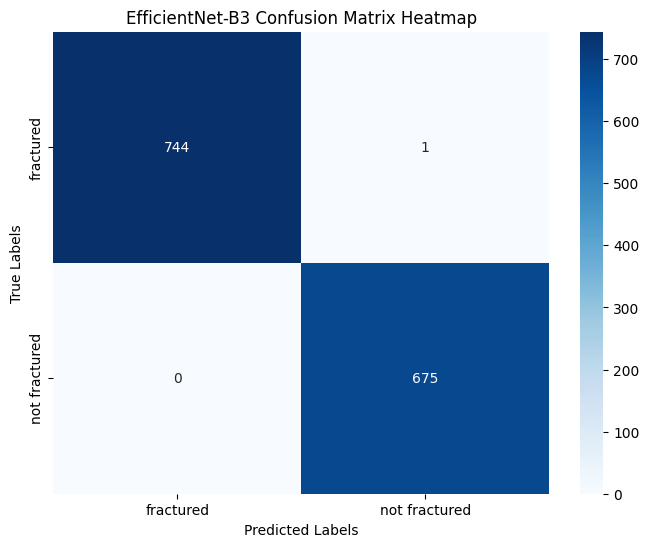

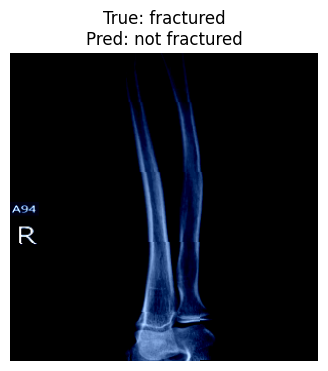

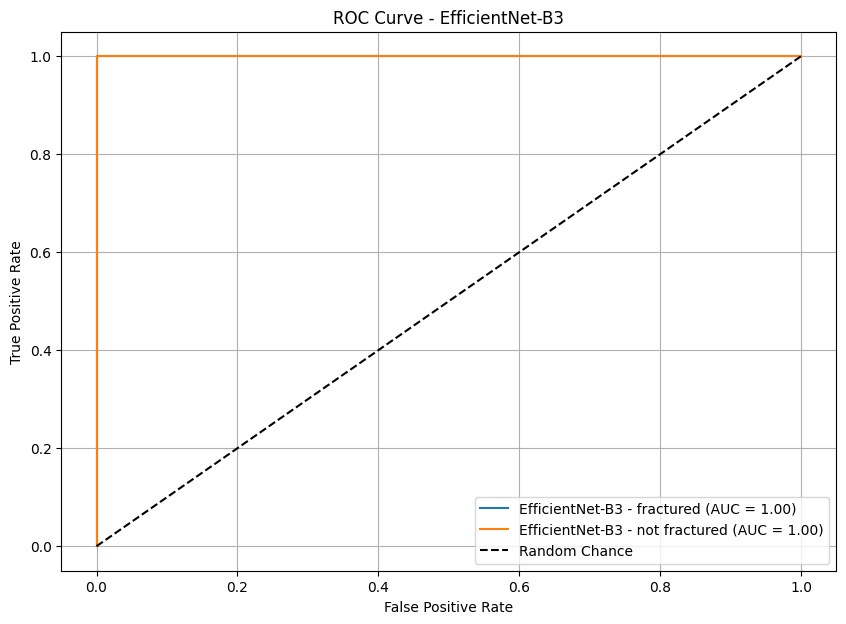

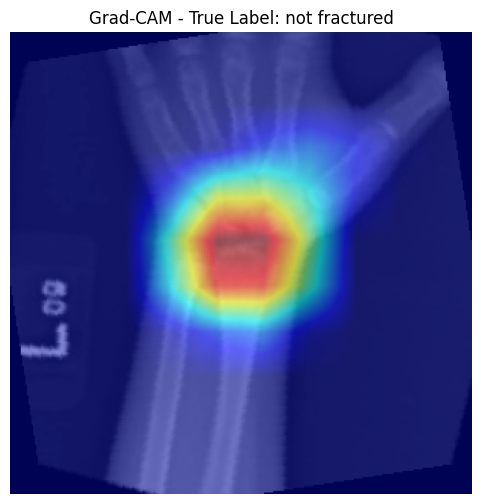

In [ ]:
from torchvision.models import efficientnet_b3
from pytorch_lightning import LightningModule
from torchmetrics.classification import MulticlassAccuracy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class EfficientNetModel(LightningModule):
    def __init__(self, num_classes):
        super(EfficientNetModel, self).__init__()

        # Load pretrained EfficientNet B3 and replace the final layer with dropout + new classifier
        self.model = efficientnet_b3(pretrained=True)
        self.model.classifier[1] = nn.Sequential(
            nn.Dropout(0.5),  # Dropout layer to reduce overfitting
            nn.Linear(self.model.classifier[1].in_features, num_classes)
        )
        self.train_losses = []
        self.val_losses = []

        # Accuracy metrics
        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc = MulticlassAccuracy(num_classes=num_classes)
        self.test_acc = MulticlassAccuracy(num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        # Use weight decay for regularization to avoid overfitting
        return optim.Adam(self.parameters(), lr=1e-4, weight_decay=1e-4)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.train_acc(y_hat.argmax(dim=1), y)

        self.train_losses.append(loss.detach())

        # print(f"[TRAIN] Batch {batch_idx} - Loss: {loss.item():.4f} | Acc: {acc.item():.4f}")
        self.log('train_loss', loss,  on_epoch=True, on_step=True, logger=True)
        self.log('train_acc', acc,  on_epoch=True, on_step=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.val_acc(y_hat.argmax(dim=1), y)

        self.val_losses.append(loss.detach())

        # print(f"[VAL] Batch {batch_idx} - Loss: {loss.item():.4f} | Acc: {acc.item():.4f}")
        self.log('val_loss', loss, on_epoch=True, on_step=True, logger=True)
        self.log('val_acc', acc, on_epoch=True, on_step=True, logger=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.test_acc(y_hat.argmax(dim=1), y)

        # print(f"[TEST] Batch {batch_idx} - Loss: {loss.item():.4f} | Acc: {acc.item():.4f}")
        self.log('test_loss', loss,  on_epoch=True, on_step=True, logger=True)
        self.log('test_acc', acc,  on_epoch=True, on_step=True, logger=True)
        return loss

    def on_train_epoch_end(self):
        avg_train_loss = torch.stack(self.train_losses).mean()
        avg_val_loss = torch.stack(self.val_losses).mean()

        self.log('train_loss_epoch', avg_train_loss, on_epoch=True, logger=True)
        self.log('val_loss_epoch', avg_val_loss, on_epoch=True, logger=True)
        # Ensure accuracy stays on screen continuously, no resetting
        self.log('train_acc', self.train_acc.compute(), on_epoch=True, on_step=False, logger=True, sync_dist=True)
        self.log('val_acc', self.val_acc.compute(),  on_epoch=True, on_step=False, logger=True, sync_dist=True)
        self.log('test_acc', self.test_acc.compute(),  on_epoch=True, on_step=False, logger=True, sync_dist=True)

        print(f"Epoch {self.current_epoch} - Train Acc: {self.train_acc.compute().item():.4f} | Val Acc: {self.val_acc.compute().item():.4f}")
        print(f"Train Loss: {avg_train_loss.item():.4f} | Val Loss: {avg_val_loss.item():.4f}")

        self.train_losses.clear()
        self.val_losses.clear()

    def on_test_epoch_end(self):
        test_accuracy = self.test_acc.compute().item()
        print(f"Epoch {self.current_epoch} - Test Accuracy: {test_accuracy:.4f}")



# For EfficientNet Model
model_type = "efficientnet"
data_module = ImageDataModule(train_data, test_data, model_type)
data_module.setup()

# Print dataset information
print(f"Number of training images: {len(data_module.train_dataset)}")
print(f"Number of testing images: {len(data_module.test_dataset)}")
print(f"Number of validation images: {len(data_module.val_dataset)}")

# Create DataLoader
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

# Initialize the Trainer
trainer = Trainer(max_epochs=10, accelerator=accelator, devices=1)

# Initialize the EfficientNet-B3 Model
efficientnet_model = EfficientNetModel(num_classes=len(unique_classes))

# Train the EfficientNet-B0 Model
trainer.fit(efficientnet_model, train_dataloaders=train_loader, val_dataloaders=val_loader)
y_true, y_pred, y_pred_proba = evaluate_model("EfficientNet-B3", efficientnet_model, test_loader, unique_classes, device)
plot_confusion_matrix(y_true, y_pred, unique_classes, "EfficientNet-B3")
plot_misclassified_samples("EfficientNet-B3", efficientnet_model, test_loader, unique_classes, y_true, y_pred, device)
plot_roc_curve("EfficientNet-B3", y_true, y_pred_proba, num_classes=len(unique_classes), class_names=unique_classes)
visualize_gradcam(efficientnet_model, test_loader, unique_classes, device)

# Visualize Images

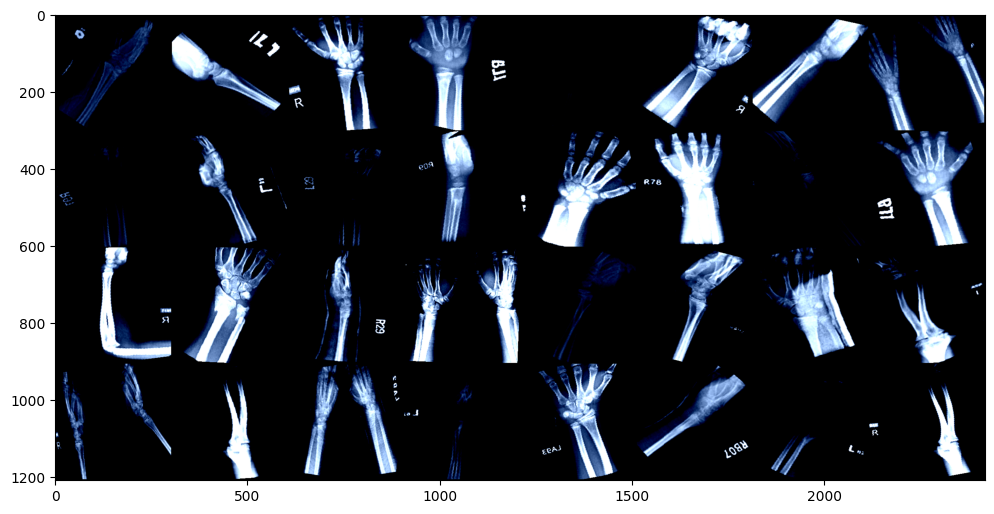

In [ ]:
for images, _ in val_loader:
    im = make_grid(images, nrow=8)
    break

plt.figure(figsize=(12, 12))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
plt.show()